In [48]:
#-*- coding: utf-8 -*-
#-*- python 3.9.6 -*-

# Author : Charles Verstraete
# Date : 2025

"""
test notebook for figures
"""

# Import libraries
import sys, os
PROJECT_ROOT = os.path.abspath("/Users/charles.verstraete/Documents/w3_iEEG/analysis_v3")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from preprocessing.config import *
from preprocessing.utils.data_helper import *
from preprocessing.utils.beh_helper import *
from preprocessing.utils.plot_helper import *

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


matplotlib.use('Qt5Agg')
plt.style.use('seaborn-v0_8-poster') 
%matplotlib inline

BEH_PATH = "/Users/charles.verstraete/Documents/w3_iEEG/behaviour/hmm"
fileslist = get_fileslist(BEH_PATH, ".csv")

df = get_df(fileslist, True, True, True)
df_test = df[np.isin(df["subject"], [13, 15, 17, 24, 29], invert=True)]

epis_count_complete = df_test.groupby(["subject", "epis"]).size().reset_index(name="count")
epis_count, removed_episodes, synthese_removed = filter_episodes(epis_count_complete, min_count=15, max_count=55)

filtered_df = df_test.merge(epis_count, on=["subject", "epis"], how="right")
filtered_df = filtered_df[filtered_df["criterion"] == 0].copy().reset_index(drop=True)


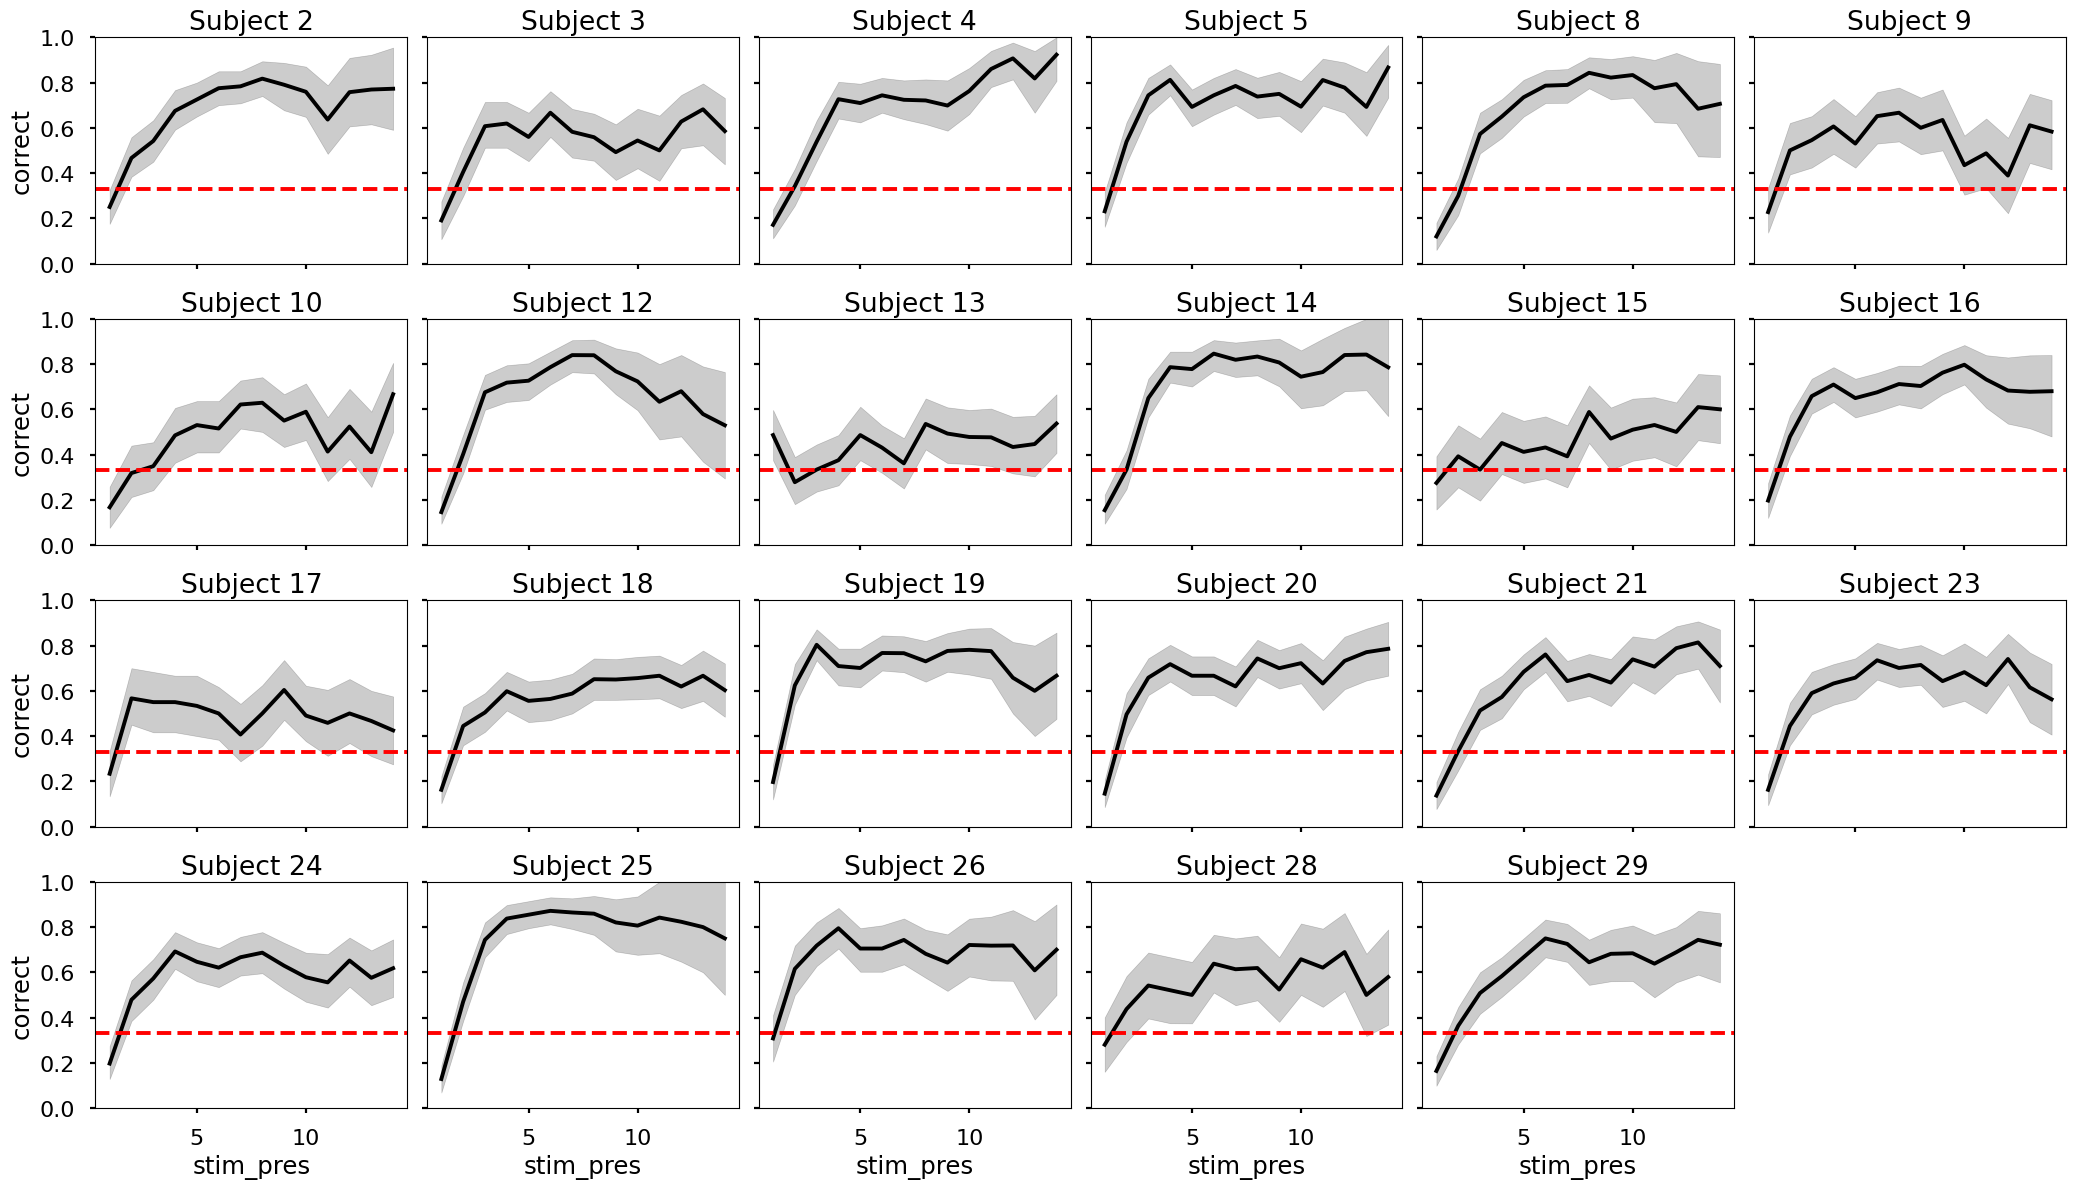

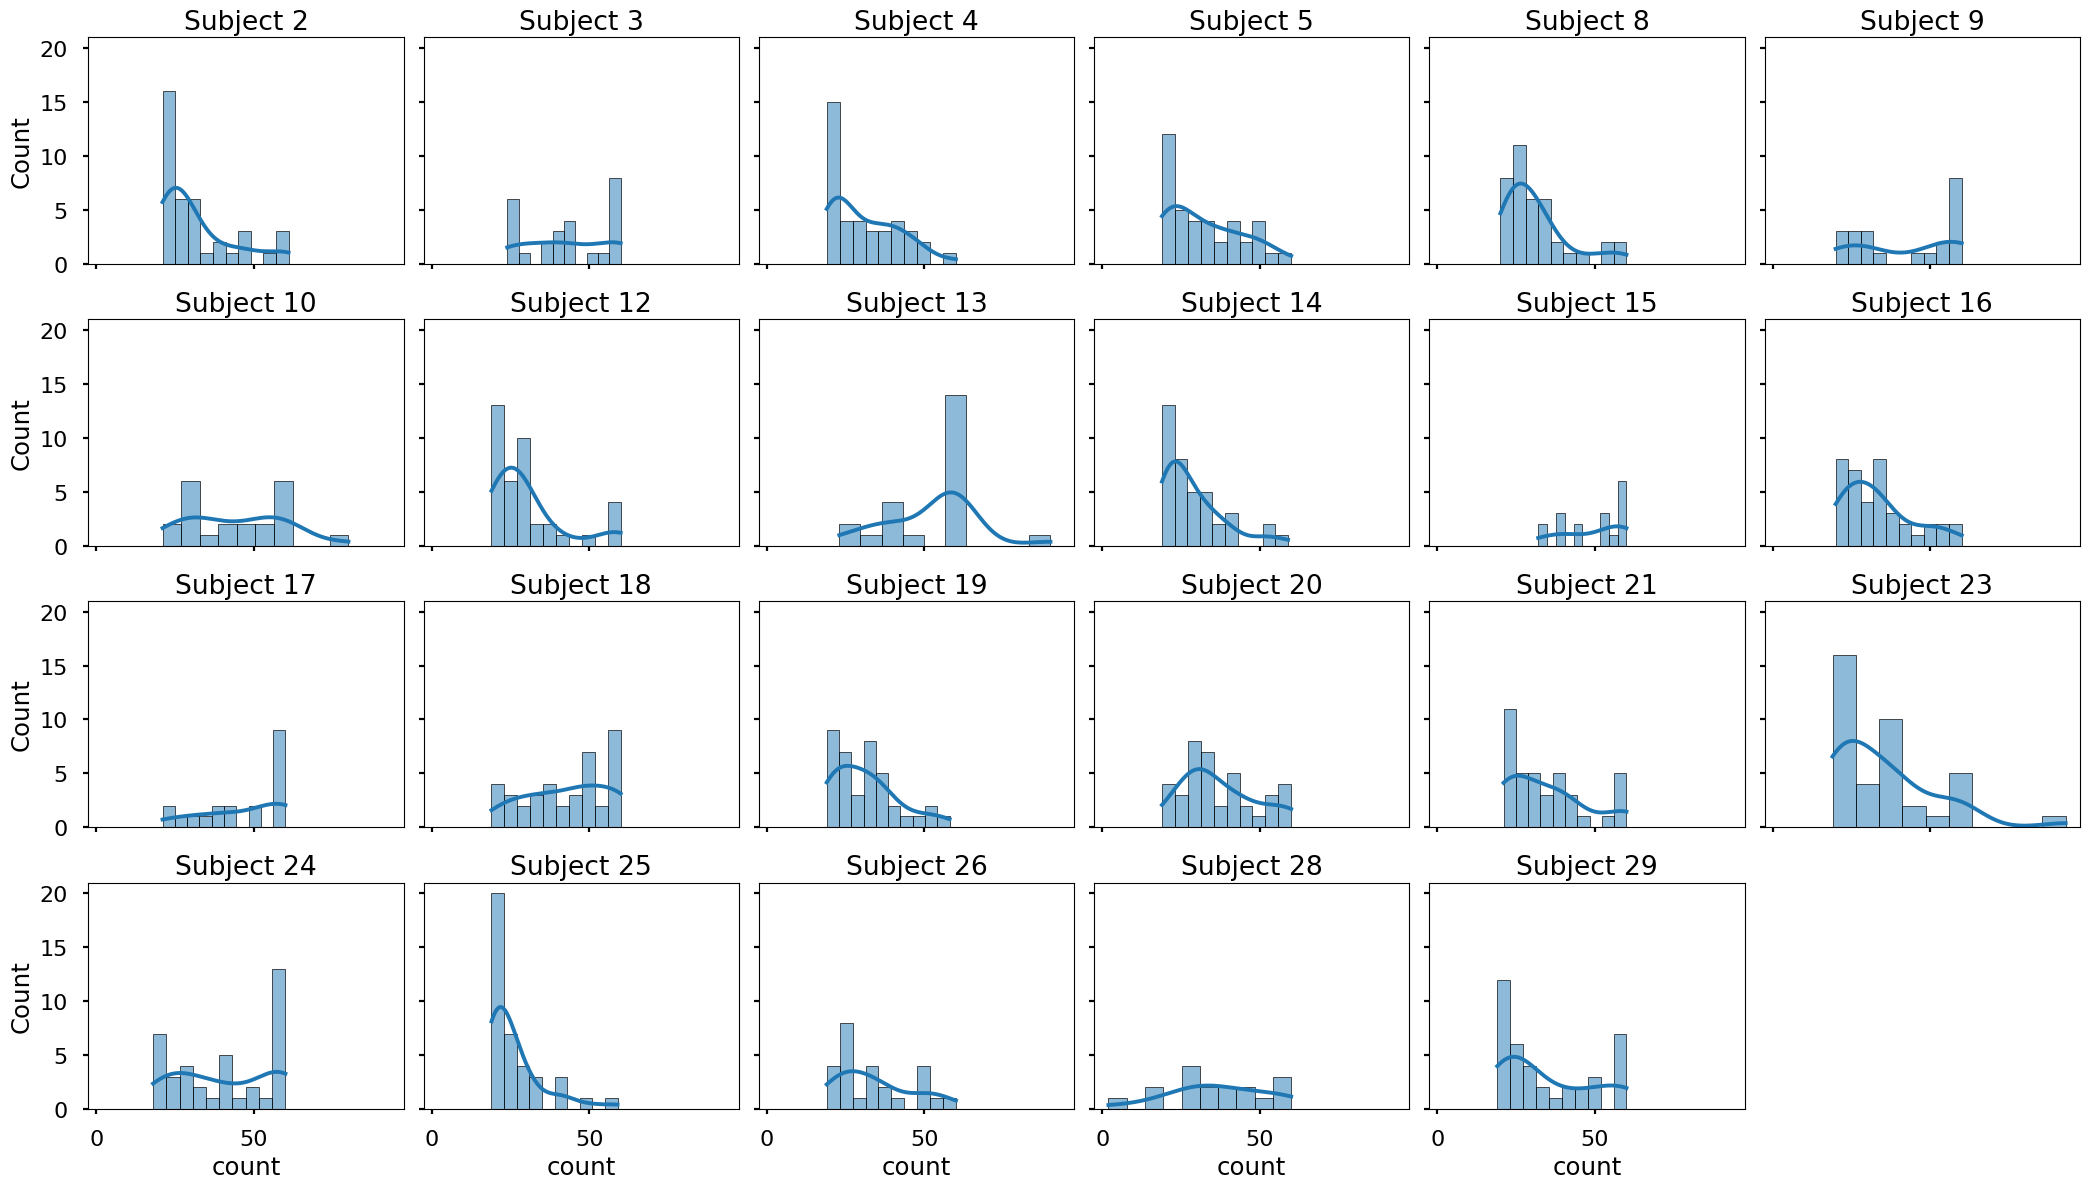

In [9]:
plot_indiv_lineplot(df, "stim_pres", "correct", xlim=15, chance=0.33, ylim=(0, 1))
plot_indiv_histplot(df, ["subject", "epis"])


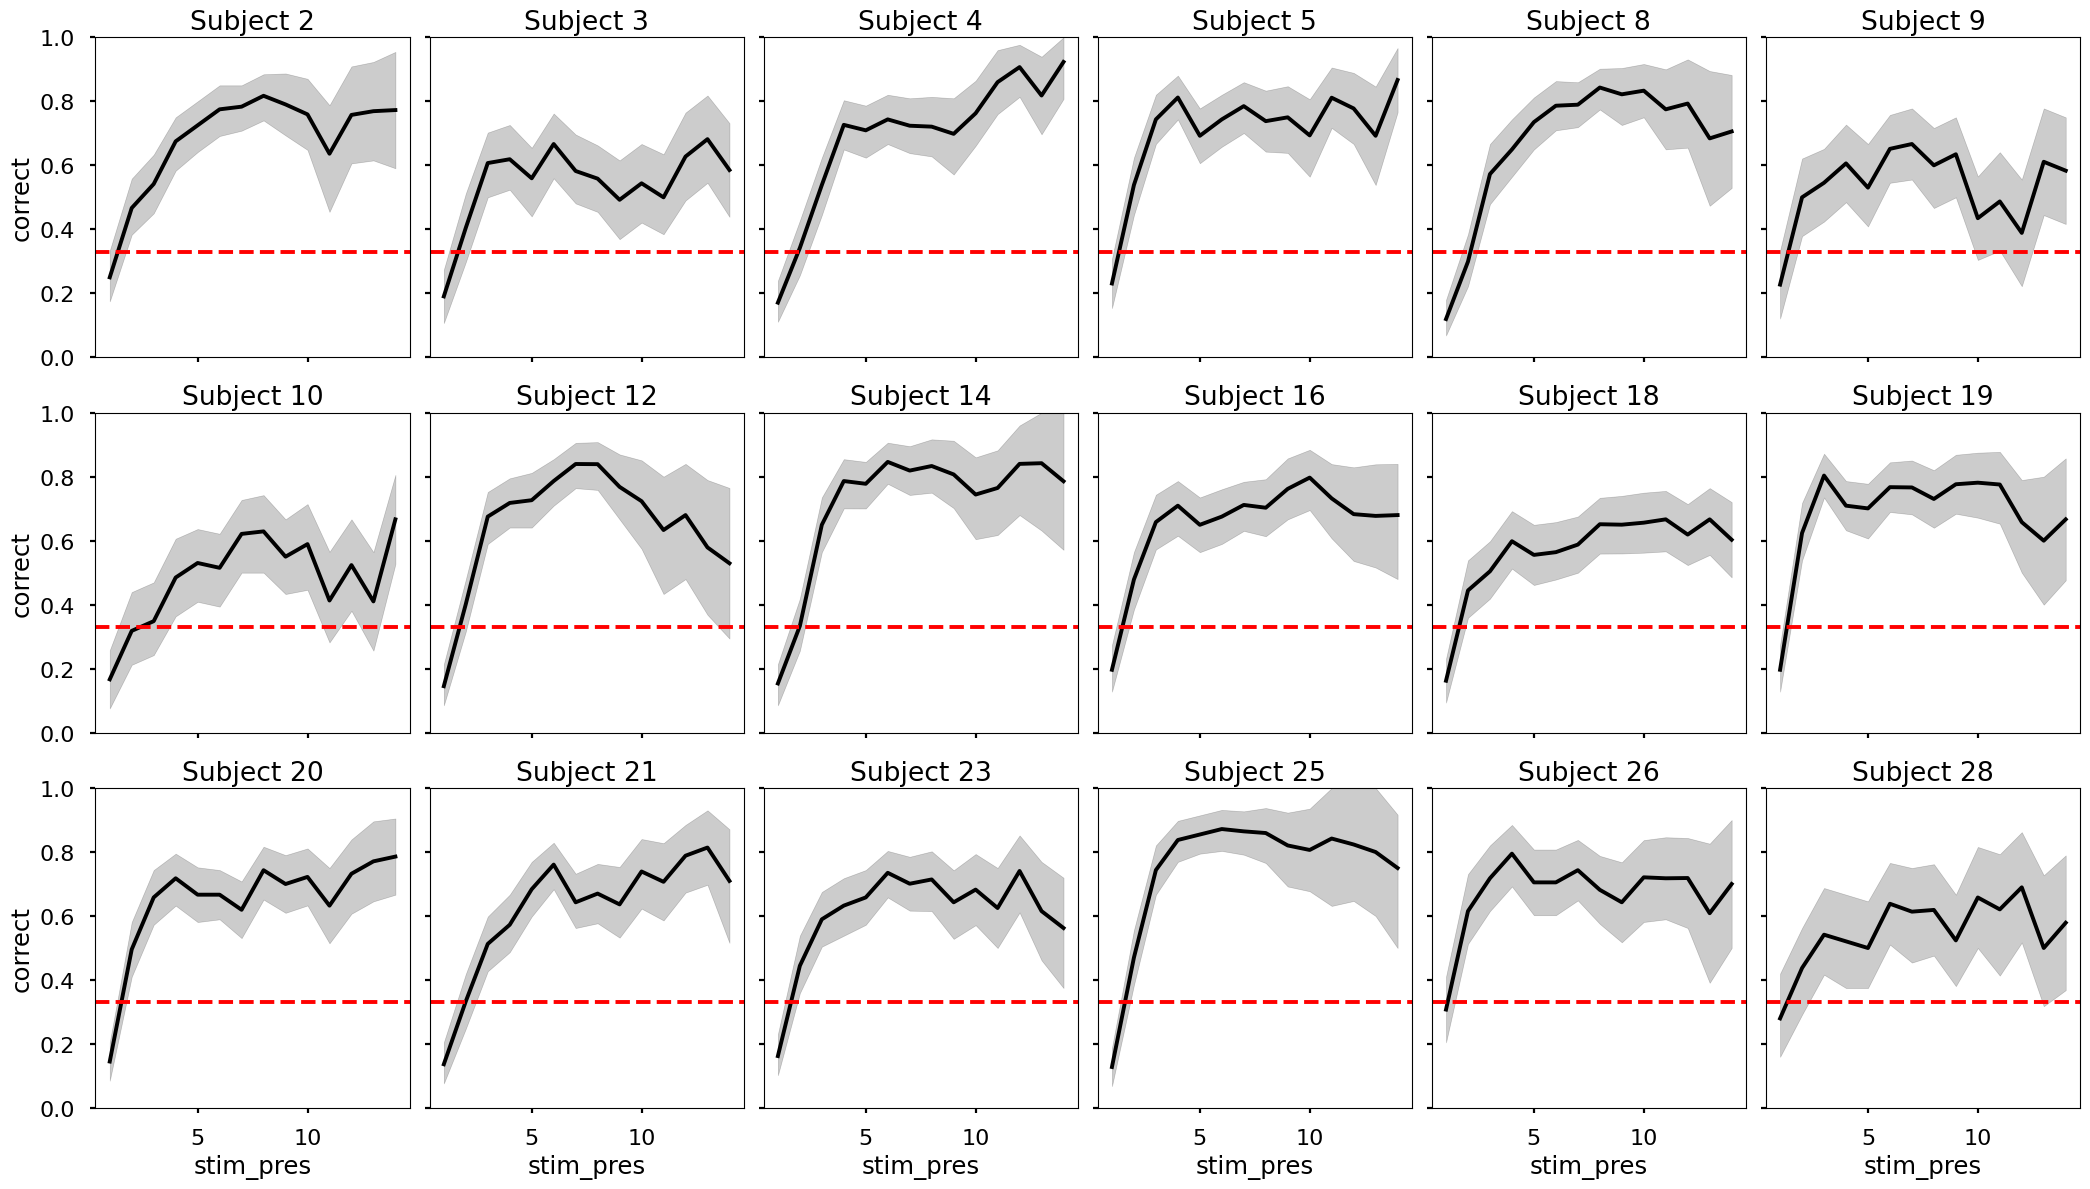

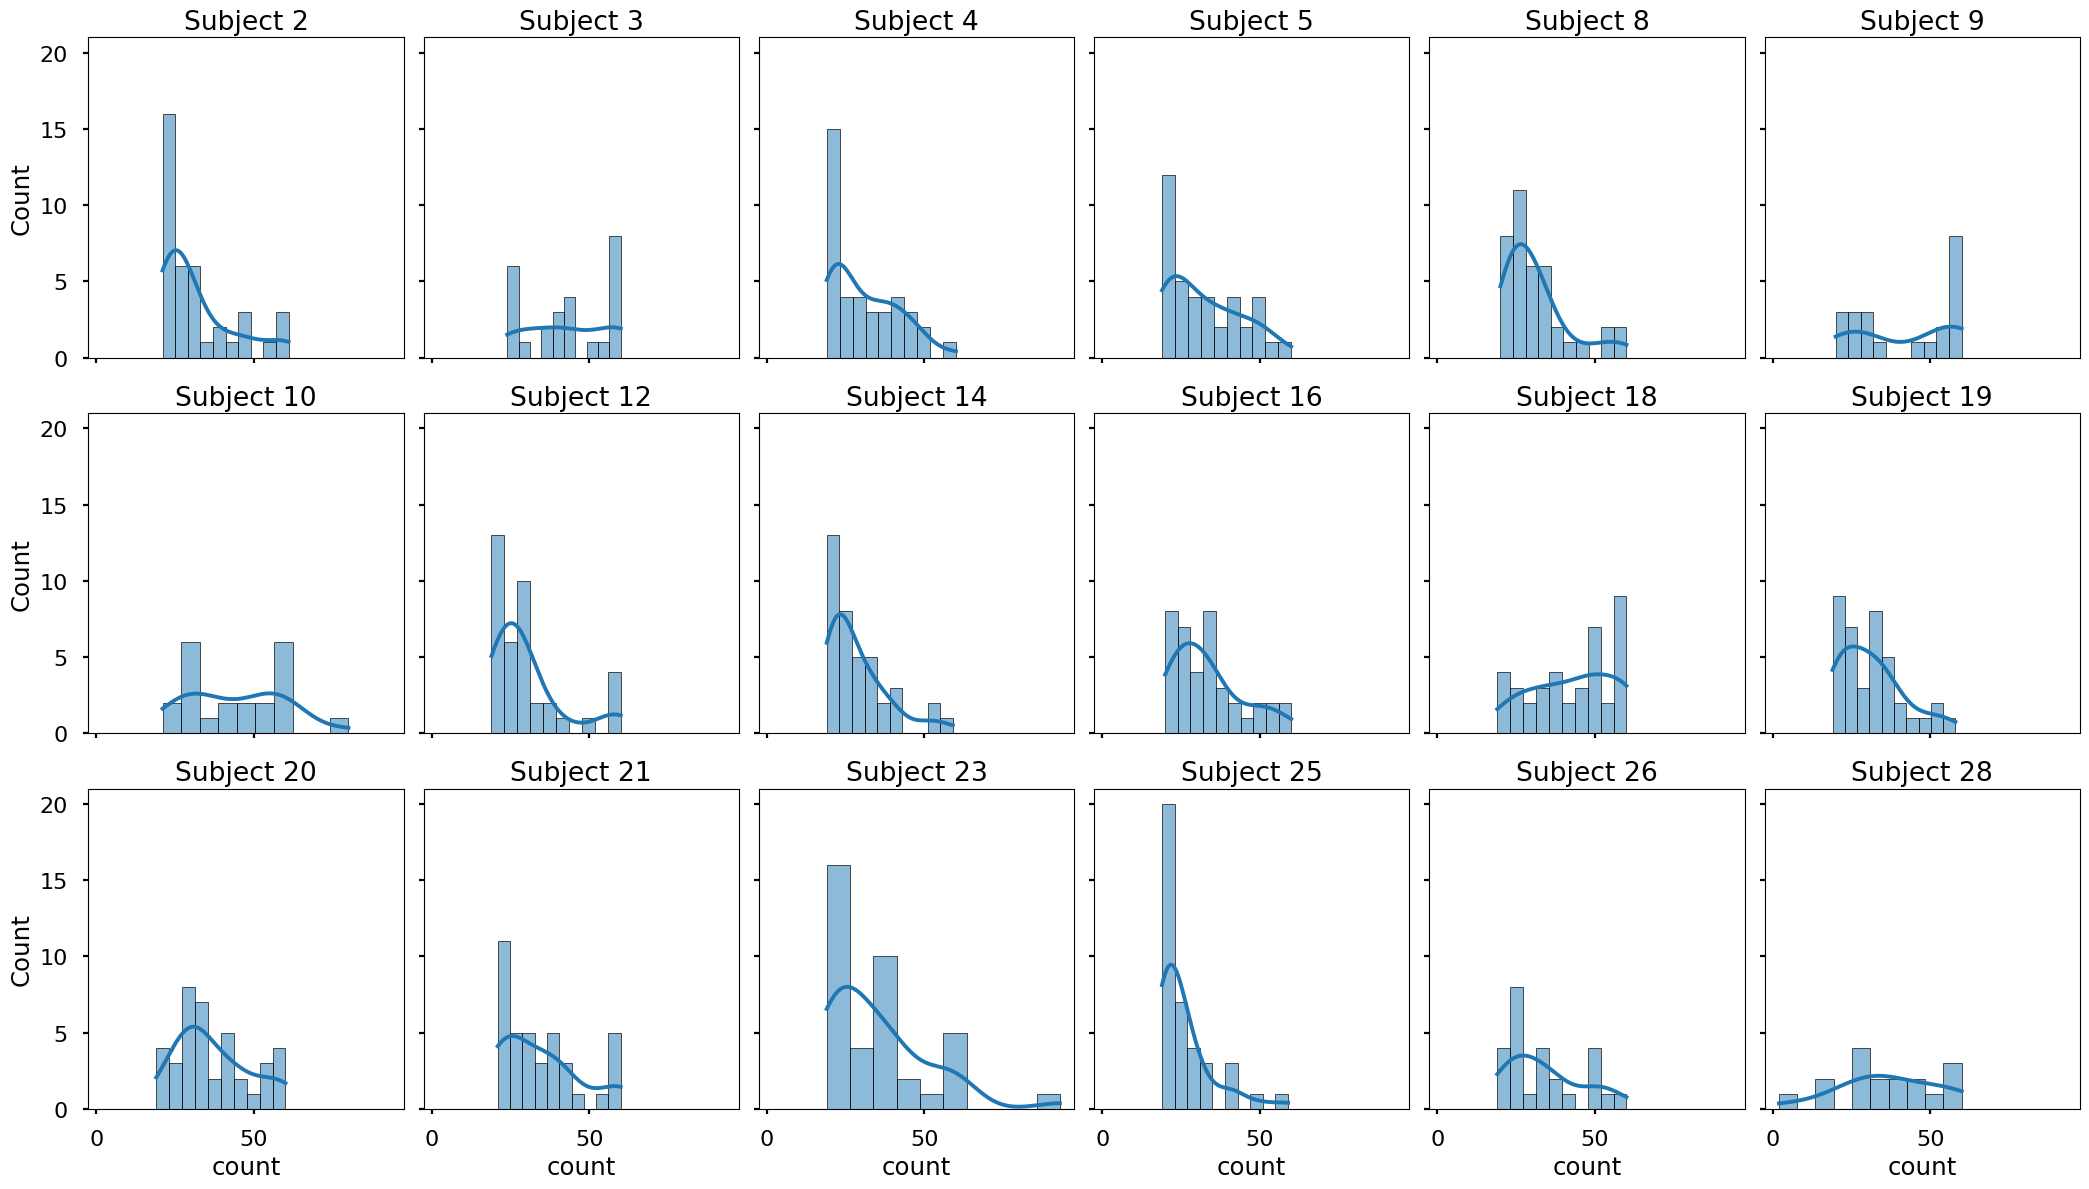

In [12]:
plot_indiv_lineplot(df_test, "stim_pres", "correct", xlim=15, chance=0.33, ylim=(0, 1))
plot_indiv_histplot(df_test, ["subject", "epis"])


In [ ]:
# good_rule = filtered_df[filtered_df["rule"] == filtered_df["hmm_strat"]].copy()
n_rows = len(filtered_df)
good_rule_switch_idx = filtered_df[filtered_df["rule"] == filtered_df["hmm_strat"]].groupby(["subject", "epis"])["trial"].idxmin().to_numpy()
switch_togood = filtered_df.loc[good_rule_switch_idx].copy().reset_index(drop=True)
switch_togood["good_rule_trial"] = 1

switch_list = []
switch_list.append(switch_togood)

for i in range(1, 8) : 
    before_switch_idx = good_rule_switch_idx - i
    before_switch_idx = before_switch_idx[before_switch_idx >= 0]

    after_switch_idx = good_rule_switch_idx + i
    after_switch_idx = after_switch_idx[after_switch_idx < n_rows]

    tmp = filtered_df.loc[before_switch_idx].copy().reset_index(drop=True)
    tmp = tmp[tmp["hmm_switch"] == 0]
    tmp["good_rule_trial"] = -i
    switch_list.append(tmp)

    tmp = filtered_df.loc[after_switch_idx].copy().reset_index(drop=True)
    tmp = tmp[tmp["hmm_strat"] == tmp["rule"]]
    tmp["good_rule_trial"] = i + 1
    switch_list.append(tmp)

switch_togood = pd.concat(switch_list, axis=0).reset_index(drop=True)


 

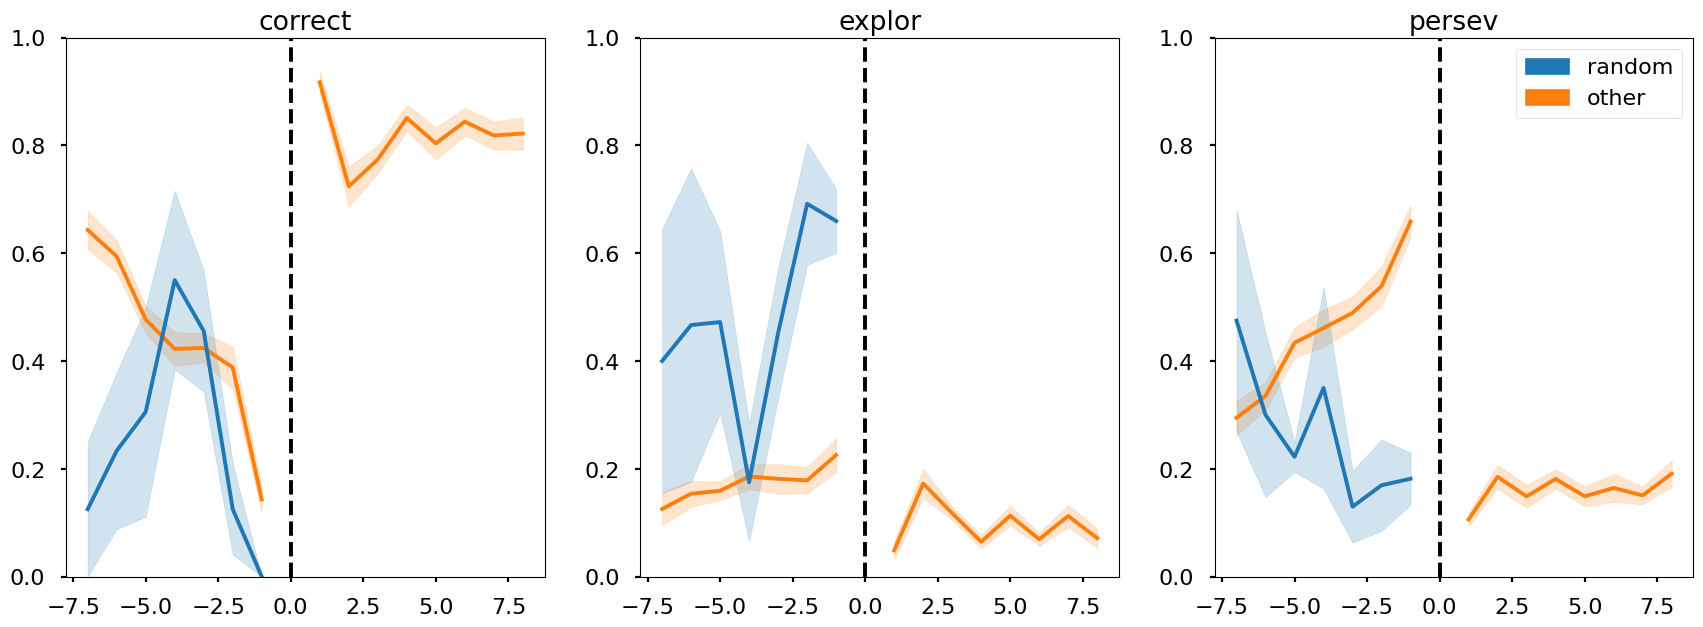

In [229]:

switch_togood["is_random"] = switch_togood["hmm_strat"] == 28

x_var_pre = "good_rule_trial"
x_var_post = "good_rule_trial"
keys = [0, 1]

fig, axs = plt.subplots(1, 3, figsize=(21, 7), sharex=True)
new_palette = {True: "tab:blue", False: "tab:orange"}

for i, y_var in enumerate(["correct", "explor", "persev"]) :
    summary_before, summary_after = get_switch_summary(switch_togood, x_var_pre, x_var_post, y_var, -9, 9, "is_random", "is_random")
    plot_timecourse_summary(summary_after, x=x_var_post, hue="is_random", keys=keys, palette=new_palette,
                            ax=axs[i], ribbon_alpha=0.2)
    plot_timecourse_summary(summary_before, x=x_var_pre, hue="is_random", keys=keys, palette=new_palette,
                            ax=axs[i], ribbon_alpha=0.2)
    axs[i].set_title(y_var)
    axs[i].axvline(0, color='black', linestyle='--')
    axs[i].set_ylim(0, 1)
plt.legend(handles=[Patch(color='tab:blue', label='random'), Patch(color='tab:orange', label='other')])



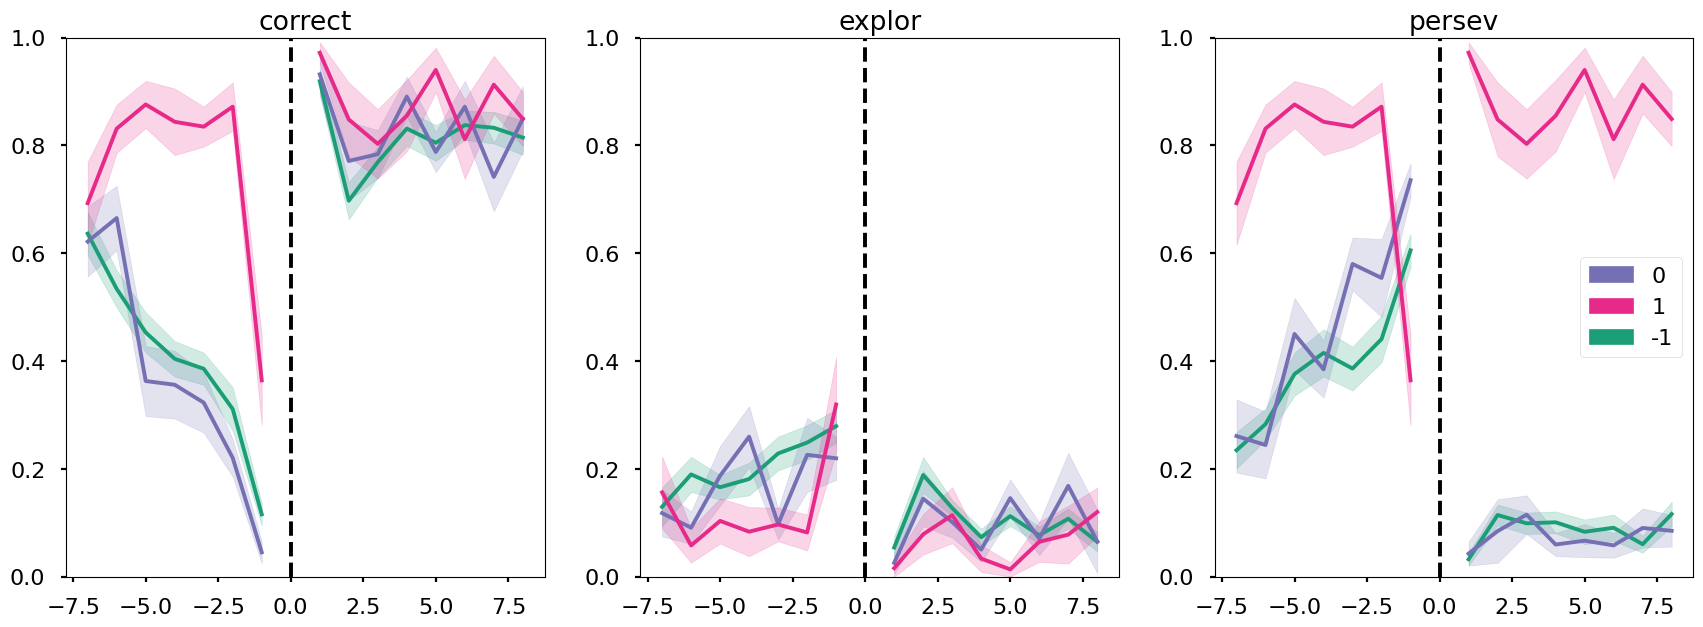

In [233]:
x_var_pre = "good_rule_trial"
x_var_post = "good_rule_trial"
keys = [-1, 0, 1]
palette_rule = {k: palette_dict[k] for k in (0, 1, -1)}

fig, axs = plt.subplots(1, 3, figsize=(21, 7), sharex=True)
# new_palette = {True: "tab:blue", False: "tab:orange"}

for i, y_var in enumerate(["correct", "explor", "persev"]) :
    summary_before, summary_after = get_switch_summary(switch_togood, x_var_pre, x_var_post, y_var, -9, 9, "is_stimstable", "is_stimstable")
    plot_timecourse_summary(summary_after, x=x_var_post, hue="is_stimstable", keys=keys, palette=palette_dict,
                            ax=axs[i], ribbon_alpha=0.2)
    plot_timecourse_summary(summary_before, x=x_var_pre, hue="is_stimstable", keys=keys, palette=palette_dict,
                            ax=axs[i], ribbon_alpha=0.2)
    axs[i].set_title(y_var)
    axs[i].axvline(0, color='black', linestyle='--')
    axs[i].set_ylim(0, 1)
plt.legend(handles=[Patch(color=c, label=l) for l, c in palette_rule.items()])


In [187]:
palette_dict

{0: (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 1: (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 -1: (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 'random': (0.5, 0.5, 0.5),
 'global': (0.835, 0.369, 0.0),
 'overlap': (0.337, 0.706, 0.914)}

(1.5, 12.0)

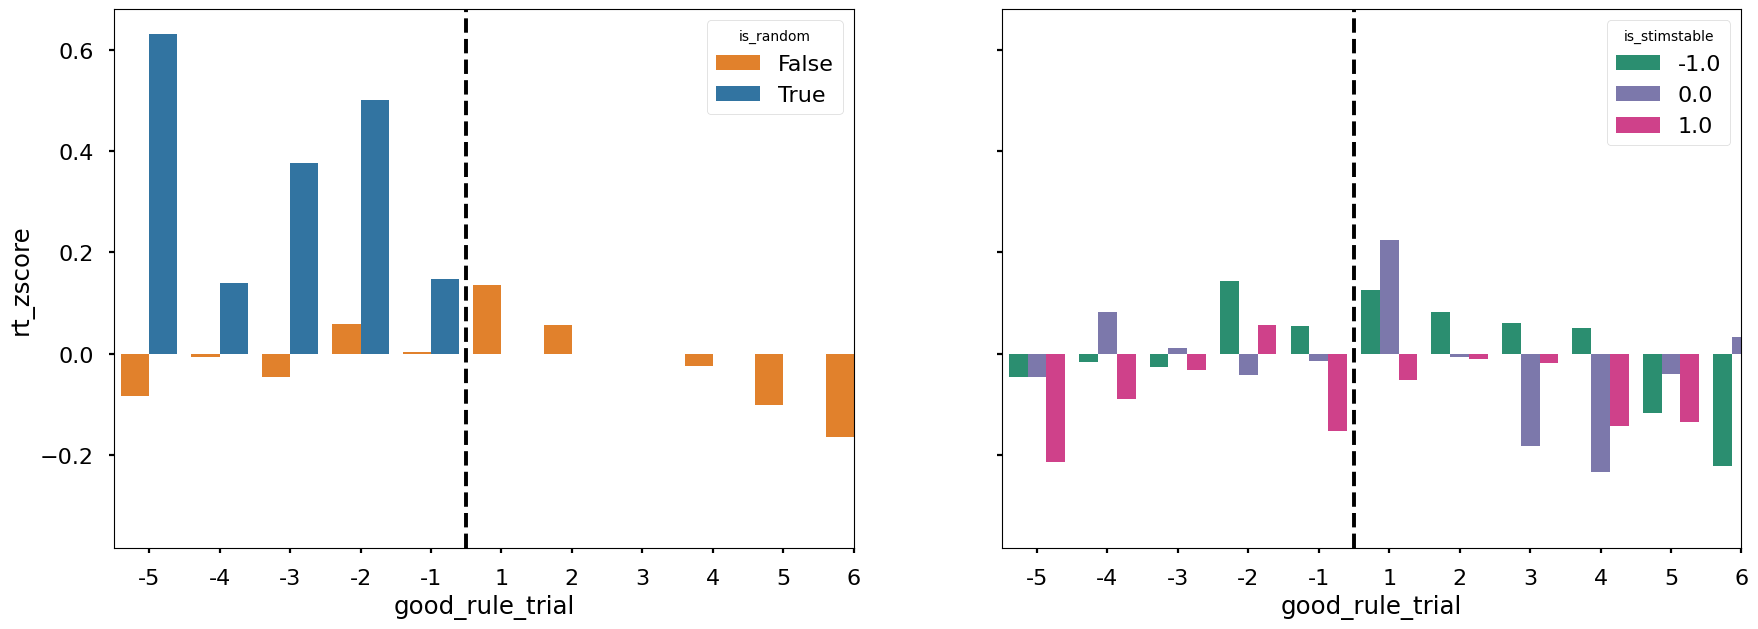

In [253]:
fig, axs = plt.subplots(1, 2, figsize=(21, 7), sharey=True, sharex=True)

sns.barplot(data=switch_togood, x="good_rule_trial", y="rt_zscore", hue="is_random", errorbar = None, ax=axs[0], palette=new_palette)
sns.barplot(data=switch_togood, x="good_rule_trial", y="rt_zscore", hue="is_stimstable", errorbar = None, ax=axs[1], palette=palette_rule)
axs[0].axvline(6.5, color='black', linestyle='--')
axs[1].axvline(6.5, color='black', linestyle='--')
axs[0].set_xlim(1.5, 12)
